# Poker Project Development Notebook

This notebook is an unordered development notebook meant for brainstorming, it is very chaotic. However, at the end there are some basis summed up for the complex bot. It is also in Spanish, any translator should do a decent enough job to understand it.

## Mean vs Median

Digamos que m_n es el dinero medio que tienes en la ronda n dados la probabilidad de ganar en la ronda n ($p_w(n)$), la fracción de tu dinero apostada en la ronda n ($f_{bet}(n)$) y el coste de jugar la ronda n por mecánicas tipo _big blind_ ($r_c(n)$). Además vamos a tratar todo multiplicativamente bajo la idea de que si tienes 100€ y los duplicas es equivalente a que tengas 1000€ y duplicarlos (independientemente del dinero que tengas esta estrategia debería asegurar unos umbrales de ganancia porcentuales, además así simplificas los cálculos).
$$m_{n+1} = m_n \cdot ((1 + f_{bet}(n)) \cdot p_w(n) + (1 - f_{bet}(n)) \cdot (1 - p_w(n))) - r_c(n)$$
$$m_{n+1} = m_n \cdot (p_w(n) + p_w(n) \cdot f_{bet}(n) + 1 - f_{bet}(n) - p_w(n) + p_w(n) \cdot f_{bet}(n)) - r_c(n)$$
$$m_{n+1} = m_n \cdot (1 + (2p_w(n) - 1) \cdot f_{bet}(n)) - r_c(n)$$
Si intentásemos optimizar esta función nos daría que cada vez que $p_w > 0.5$ deberíamos endeudarnos y apostar infinito dinero, porque a esta fórmula sólo le importa la ganancia media. El problema es que la media no es lo que nos interesa, ¿por qué?

Pongamos un juego en el que tiras una moneda hasta que salga cruz. Si no sale cara nunca te llevas 1€. Por cada vez que salga cara se multiplica por dos lo que te llevas de premio. Cuando salga cruz se acaba el juego y te llevas tu premio. Por ejemplo, sale cara 3 veces seguidas y luego cruz, pues tu premio sería de 8€ (1€ x 2 x 2 x 2). Véase que el dinero que obtienes viene dado por la fórmula $f(n) = 2^n$ siendo n el número de caras seguidas, y la probabilidad de obtener un premio $f(n)$ sigue la expresión $p(n) = \frac{1}{2^n}$.  
La idea de este constructo es preguntar, ¿cuánto debería costar participar para que el juego fuera justo, es decir, que ni el _casino_ ni el jugador pierdan dinero de media?  
Entonces vamos a calcular el beneficio medio bruto (sin restarle el coste de jugar):  
$$B_b = \sum_{i=0}^\infty p(n) \cdot f(n) = \sum_{i=0}^\infty \frac{1}{2^n} \cdot 2^n = \sum_{i=0}^\infty 1 = \infty$$
La ganancia en bruto media es infinita, así que debería costar eso mismo jugar para que el casino no pierda dinero. No obstante, ningún jugador obtendrá beneficio jugando el juego, puesto que obtener tanto beneficio es un suceso de probabilidad 0. No obstante, este juego nunca le interesaría ni al casino ni a los jugadores, porque cualquier precio que no fuera infinito provocaría que eventualmente el casino perdiera dinero, y bajo un precio infinito ningún jugador ganaría dinero.

Si en vez de maximizar la media, maximizamos la mediana/moda, obtenemos la fórmula del [criterio de Kelly](https://en.wikipedia.org/wiki/Kelly_criterion), en que la fracción de nuestro dinero $f$ que debemos apostar para maximizar el crecimiento de la mediana viene dado por:
$$f^* = p_w - \frac{1 - p_w}{b}$$
Aplicada a este caso $b = 1$:
$$f^* = 2p_w - 1$$
Cualquier valor mayor que $f^*$ arriesga más por un crecimiento menor, y cualquier valor menor que $f^*$ arriesga menos pero tardas más partidas en alcanzar la misma mediana. De hecho, si jugar una ronda tiene un coste fijo hay tal cosa como un $f$ mínimo inicial. Este viene dado por:
$$\frac{r_c(n)}{m(n)} < (1 + f)^{p_w} \cdot (1 - f)^{1 - p_w}$$
Donde recordemos que $r_c(n)$ es el coste de jugar la ronda $n$ y $m(n)$ es el dinero a nuestra disposición en esa misma ronda. No obstante este valor no modifica el valor de $f^*$, sino que acota los posibles $f$ que podamos tomar, es decir, nos obliga a jugar de forma menos segura pero no menos óptima. 

Ahora otro problema es que el póker no es un juego en que se apuesta una vez, sino que hay una competición de apuestas, en que si no apuestas suficiente, pierdes todo lo previamente apostado.

Si nadie sube nuestra apuesta, no hay problema, si al recalcular $f^*$ es menor se _iría_ y si es mayor se subiría al nuevo valor. El problema es que alguien suba la apuesta y que esto sea por encima de nuestro nuevo $f^*$. Si ese valor nos provoca, estadísticamente hablando, pérdidas mayores que retirarse, deberíamos retirarnos\*. Si ese valor no nos produce pérdidas mayores que retirarse, se presenta un problema, que su valor siga subiendo, porque podría ser que fuera incrementando ronda a ronda y se perdieran cantidades mayores, pero estadísticamente hablando serían las mejores decisiones (pensando a corto plazo).

No obstante, el resto de jugadores no están haciendo lo mismo que el modelo estadístico. Por ejemplo, estadísticamente apostarse todo nunca es ni seguro ni aceptable, pero los jugadores no lo ven así. Hay una parte externa que el modelo no puede controlar, entonces no podemos usar el modelo estadístico para esos casos, pero sentará una buena base.  

Ejemplos de esta ocurrencia, que el oponente esté tirándose un farol, en cuyo caso retirarse sería impreciso. Además es muy común que alguien que se tira un farol, apueste una cantidad desorbitada, lo cual el modelo estadístico detectaría que está fuera de los margenes y se retiraría, pudiéndose uno aprovecharse de este. Otra ocurrencia común es que alguien en la mesa tenga suficiente dinero como para apostar el máximo que pudiera otro jugador, caso en que el bot volvería a rendirse.

Siempre que la apuesta actual esté por encima de una apuesta aceptable y que tengamos que decidir entre igualar o retirarnos debemos considerar otro _modus operandi_.

Una buena forma sería estimar las probabilidades de ganar según la diferencia de dinero y decidir en qué situación ponerse dependiendo de esas probabilidad. Por ejemplo, el oponente ha hecho que tenga que hacer _all in_, retirarse supone una situación desfavorable en la cual mis probabilidades de ganar son del 30%, pero las probabilidades de ganar con mi mano son sólo del 30%, si gano mi mano tengo un 95% de ganar y si la pierdo 0% (trivialmente), entonces teniendo en cuenta eso: 30% vs 30% $\cdot$ 95% = 28.5% (deberíamos retirarnos).

Para estimar estas probabilidades de ganar tomamos el caso en que, antes de ver las cartas, ambos tienen la misma probabilidad de ganar, entonces podemos montar una simulación extremadamente rudimentaria pero que nos va ayudar a ilustrar cómo estimar estas probabilidades:

# Basic simmulations

Vamos a tomar dos cotas, el caso en que el va perdiendo decida cuánto se apuesta y el caso en que el que tenga más dinero decide cuánto se apuesta, además vamos a comprobar más adelante que cambiar de técnica resulta en los mismos resultados:

In [123]:
import random

def simmulate_underdog(
    topdog: int,
    underdog: int,
    betting_frac: float,
    round_cost: int
) -> int:
    '''
    Simmulate a simple model of a betting game between two players with 
    different amounts of money. Underdog decides the amount bet.
    Args:
        topdog (int): The amount of money the player with the most money has.
        underdog (int): The amount of money the player with the least money has.
        betting_frac (float): The fraction of the underdog's money that is bet.
        round_cost (int): The cost of a round.
    '''
    
    topdog_id = 1
    while underdog > 0:
        betting_ammount = max(round_cost, underdog * betting_frac)
        if random.randint(0, 1) == 0:
            topdog += betting_ammount
            underdog -= betting_ammount
        else:
            topdog -= betting_ammount
            underdog += betting_ammount
            if underdog > topdog:
                underdog, topdog = topdog, underdog
                topdog_id = topdog_id % 2 + 1

    return topdog_id

In [ ]:
player1_money = 1000 # Topdog
player2_money = 100 # Underdog
N = 200000

for round_cost in [1, 2, 5, 10, 20, 50, 100]:
    results = [simmulate_underdog(player1_money, player2_money, 0.5, round_cost) for i in range(N)]
    print(results.count(1) / N, results.count(2) / N)
# Se ve que el roundcost no afecta tanto al resultado final incluso con 
# disparidades tan grandes de dinero, así que se eligirá el round_cost de 1
# (para que el jugador con 100 pueda jugar 100 rondas)

0.909245 0.090755
0.90739 0.09261
0.90691 0.09309
0.905005 0.094995
0.900135 0.099865
0.896645 0.103355
0.901835 0.098165


In [136]:
N = 50000
player1_money = 1000
player2_money = 100

# Véase que a distintas fracciones de apuesta, los porcentajes de victoria 
# se mantienen (aproximadamente)
results = [simmulate_underdog(player1_money, player2_money, 0.1, 1) for i in range(N)]
print(results.count(1) / N, results.count(2) / N)
results = [simmulate_underdog(player1_money, player2_money, 0.9, 1) for i in range(N)]
print(results.count(1) / N, results.count(2) / N)

0.90888 0.09112
0.90702 0.09298


In [137]:
N = 50000
player1_money = 1000
for player2_fraction in [0.1, 0.25, 0.5, 0.75]:
    results = [
        simmulate_underdog(player1_money, player1_money*player2_fraction, 0.5, 1)
        for i in range(N)
    ]
    real_topdog_winrate = results.count(1) / N
    real_underdog_winrate = results.count(2) / N
    print(f'    Real: {real_topdog_winrate:.1%} {real_underdog_winrate:.1%}')
    
    # Digamos que la probabilidad de ganar es un reparto proporcional al dinero
    expected_topdog_winrate = 1/(player2_fraction+1)
    expected_underdog_winrate = player2_fraction/(player2_fraction+1)
    print(f'Expected: {expected_topdog_winrate:.1%} {expected_underdog_winrate:.1%}')
    print()
    
# Podemos ver que el modelo es bastante preciso

    Real: 90.8% 9.2%
Expected: 90.9% 9.1%

    Real: 80.2% 19.8%
Expected: 80.0% 20.0%

    Real: 66.8% 33.2%
Expected: 66.7% 33.3%

    Real: 57.5% 42.5%
Expected: 57.1% 42.9%



In [109]:
# No tomamos en cuenta el round cost, porque la idea es que el topdog decida y 
# siempre debería decidir valores más grandes (sino el roundcost sería 
# demasiado alto)
def simmulate_topdog(
    topdog: int,
    underdog: int,
    betting_frac: float
    ) -> int:
    '''
    Simmulate a simple model of a betting game between two players with 
    different amounts of money. Topdog decides the amount bet.
    Args:
        topdog (int): The amount of money the player with the most money has.
        underdog (int): The amount of money the player with the least money has.
        betting_frac (float): The fraction of the topdog's money that is bet.
    '''
    
    topdog_id = 1
    while underdog > 0:
        betting_ammount = min(underdog, topdog * betting_frac)
        if random.randint(0, 1) == 0:
            topdog += betting_ammount
            underdog -= betting_ammount
        else:
            topdog -= betting_ammount
            underdog += betting_ammount
            if underdog > topdog:
                underdog, topdog = topdog, underdog
                topdog_id = topdog_id % 2 + 1

    return topdog_id

In [117]:
N = 50000
player1_money = 1000
player2_money = 200

# Véase que a distintas fracciones de apuesta, los porcentajes de victoria se 
# mantienen en este caso también
results = [simmulate_topdog(player1_money, player2_money, 0.1) for i in range(N)]
print(results.count(1) / N, results.count(2) / N)
results = [simmulate_topdog(player1_money, player2_money, 0.9) for i in range(N)]
print(results.count(1) / N, results.count(2) / N)

0.83234 0.16766
0.83582 0.16418


In [108]:
N = 50000
player1_money = 1000
for player2_fraction in [0.1, 0.25, 0.5, 0.75]:
    results = [
        simmulate_topdog(player1_money, player1_money*player2_fraction, 0.5)
        for i in range(N)
    ]
    real_topdog_winrate = results.count(1) / N
    real_underdog_winrate = results.count(2) / N
    print(f'    Real: {real_topdog_winrate:.1%} {real_underdog_winrate:.1%}')
    
    # Digamos que la probabilidad de ganar es un reparto proporcional al dinero
    expected_topdog_winrate = 1/(player2_fraction+1)
    expected_underdog_winrate = player2_fraction/(player2_fraction+1)
    print(f'Expected: {expected_topdog_winrate:.1%} {expected_underdog_winrate:.1%}')
    print()
    
# Descubrimos que da igual quién decida la fracción de apuestas, esto se debe 
# porque la situación es simétrica, y por muy mala que sea una estrategia, 
# ambos están llevando a cabo la misma, entonces aunque una estrategia aumente 
# las probabilidades de que el topdog gane, si el underdog remonta, tiene esa 
# probabilidad extra de ganar.

    Real: 91.0% 9.0%
Expected: 90.9% 9.1%

    Real: 80.1% 19.9%
Expected: 80.0% 20.0%

    Real: 67.0% 33.0%
Expected: 66.7% 33.3%

    Real: 56.9% 43.1%
Expected: 57.1% 42.9%



Vamos a comprobar un modelo no simétrico por asegurar

In [5]:
import random
def simmulate_mixed(
    topdog: int,
    underdog: int,
    betting_frac: float,
    round_cost: int
    ) -> int:
    '''
    Simmulate a simple model of a betting game between two players with 
    different amounts of money. Player 1 always decides the ammount to bet.
    Args:
        topdog (int): The amount of money the player with the most money has.
        underdog (int): The amount of money the player with the least money has.
        betting_frac (float): The fraction of the topdog's money that is bet.
    '''
    
    topdog_id = 1
    while underdog > 0:
        if topdog_id == 1:
            betting_ammount = min(underdog, topdog * betting_frac)
        else:
            min_ammount = min(underdog, round_cost)
            intended_ammount = min(underdog, underdog * betting_frac)
            betting_ammount = max(min_ammount, intended_ammount)

            
        if random.randint(0, 1) == 0:
            topdog += betting_ammount
            underdog -= betting_ammount
        else:
            topdog -= betting_ammount
            underdog += betting_ammount
            if underdog > topdog:
                underdog, topdog = topdog, underdog
                topdog_id = topdog_id % 2 + 1

    return topdog_id

In [6]:
N = 50000
player1_money = 1000
player2_money = 200

# Véase que a distintas fracciones de apuesta, los porcentajes de victoria se 
# mantienen en este caso también
results = [simmulate_mixed(player1_money, player2_money, 0.1, 1) for i in range(N)]
print(results.count(1) / N, results.count(2) / N)
results = [simmulate_mixed(player1_money, player2_money, 0.9, 1) for i in range(N)]
print(results.count(1) / N, results.count(2) / N)

0.83528 0.16472
0.83422 0.16578


In [7]:
N = 50000
player1_money = 1000
for player2_fraction in [0.1, 0.25, 0.5, 0.75]:
    results = [
        simmulate_mixed(player1_money, player1_money*player2_fraction, 0.5, 2)
        for i in range(N)
    ]
    real_topdog_winrate = results.count(1) / N
    real_underdog_winrate = results.count(2) / N
    print(f'    Real: {real_topdog_winrate:.1%} {real_underdog_winrate:.1%}')
    
    # Digamos que la probabilidad de ganar es un reparto proporcional al dinero
    expected_topdog_winrate = 1/(player2_fraction+1)
    expected_underdog_winrate = player2_fraction/(player2_fraction+1)
    print(f'Expected: {expected_topdog_winrate:.1%} {expected_underdog_winrate:.1%}')
    print()
    
# Incluso en el modelo no simétrico siguen cumpliéndose la misma tendencia en 
# las probabilidades de ganar

    Real: 91.0% 9.0%
Expected: 90.9% 9.1%

    Real: 80.3% 19.7%
Expected: 80.0% 20.0%

    Real: 66.7% 33.3%
Expected: 66.7% 33.3%

    Real: 57.4% 42.6%
Expected: 57.1% 42.9%



In [ ]:
import random
def simmulation_allin_wait(
    p1: float,
    p2: float,
    min_p1: float,
    min_p2: float,
    round_cost: int
):
    while p1 > 0 and p2 > 0:
        p1_hand = random.random()
        p2_hand = random.random()
        if p1_hand >= min_p1 and p2_hand < min_p2:
            p1 += round_cost
            p2 -= round_cost
        elif p2_hand >= min_p2 and p1_hand < min_p1:
            p2 += round_cost
            p1 -= round_cost
        elif p1_hand < min_p1 and p2_hand < min_p2:
            continue
        else:
            betting_ammount = min(p1, p2)
            if p1_hand > p2_hand:
                p1 += betting_ammount
                p2 -= betting_ammount
            else:
                p2 += betting_ammount
                p1 -= betting_ammount
    return 1 if p1 > 0 else 2


from collections import Counter
N = 100000
c = Counter(simmulation_allin_wait(100, 200, 0.5, 0.99, 10) for i in range(N))
print(f'Player 1 winrate: {c[1]/N:.1%}')
print(f'Player 2 winrate: {c[2]/N:.1%}')

Player 1 winrate: 93.6%
Player 2 winrate: 6.4%


0it [00:00, ?it/s]

50it [02:13,  2.66s/it]


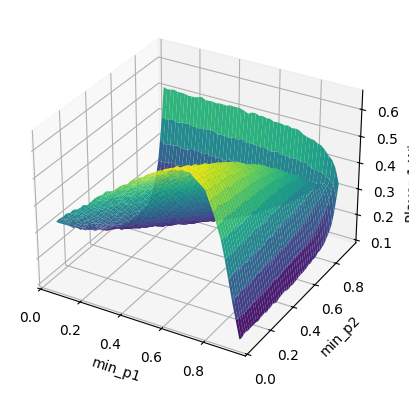

In [ ]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

import matplotlib.pyplot as plt

N = 20000
min_p1_values = np.linspace(0.05, 0.95, 50, endpoint=False)
min_p2_values = np.linspace(0.05, 0.95, 50, endpoint=False)
win_rates = np.zeros((len(min_p1_values), len(min_p2_values)))

for i, min_p1 in tqdm(enumerate(min_p1_values)):
    for j, min_p2 in enumerate(min_p2_values):
        c = Counter(simmulation_allin_wait(100, 200, min_p1, min_p2, 10) for _ in range(N))
        win_rates[i, j] = c[1] / N

min_p1_grid, min_p2_grid = np.meshgrid(min_p1_values, min_p2_values)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(min_p1_grid, min_p2_grid, win_rates.T, cmap='viridis')

ax.set_xlabel('min_p1')
ax.set_ylabel('min_p2')
ax.set_zlabel('Player 1 Win Rate')

plt.show()

In [ ]:
min_p1_grid[0, win_rates[:,0].argmax()]

np.float64(0.6960000000000001)

Si nos fijamos en el caso de que ambos esperan a tener una mano igual de buena (que desde la partida podría analizarse como apostar tan a menudo como el rival), se mantiene el reparto lineal de la probabilidad de ganar. Así que la tendencia se sigue cumpliendo.

(0.0, 1.0)

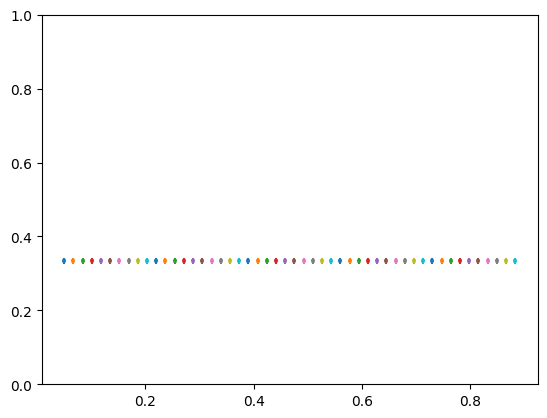

In [ ]:
plt.plot(min_p1_grid, win_rates.diagonal())
plt.ylim(0.0, 1.0)

## Median Formula Display

0.0


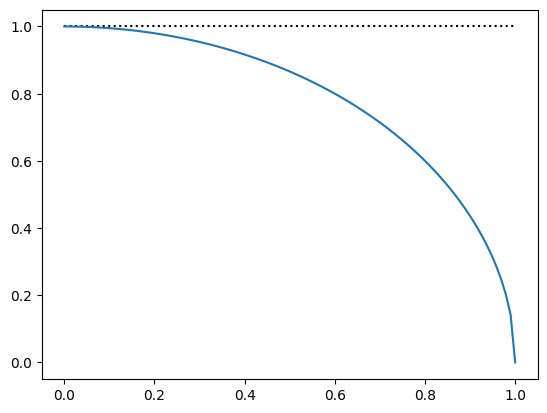

In [2]:
# Visualización de la tendencia de crecimiento de la mediana según la probabilidad de ganar
# (Entendiblemente con 50% de probabilidad de ganar, no recomienda apostar, porque no se prevee ganancia)
import numpy as np
import matplotlib.pyplot as plt
f = np.linspace(0, 1, 100)
p = 0.5
r = (1 + f)**p * (1 - f)**(1-p)
#plt.ylim(2 - r.max(), r.max())
plt.hlines(1, 0, 1, ls=':', color='black')
plt.plot(f, r)
print(f[r.argmax()])

0.797979797979798


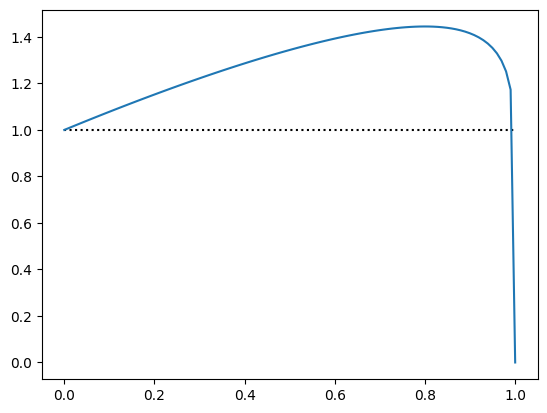

In [ ]:
f = np.linspace(0, 1, 100)
p = 0.9 # Ni con 90% de ganar se debería hacer all in porque a la larga se pierde
r = (1 + f)**p * (1 - f)**(1-p)
#plt.ylim(2 - r.max(), r.max())
plt.hlines(1, 0, 1, ls=':', color='black')
plt.plot(f, r)
print(f[r.argmax()])

0.20202020202020204


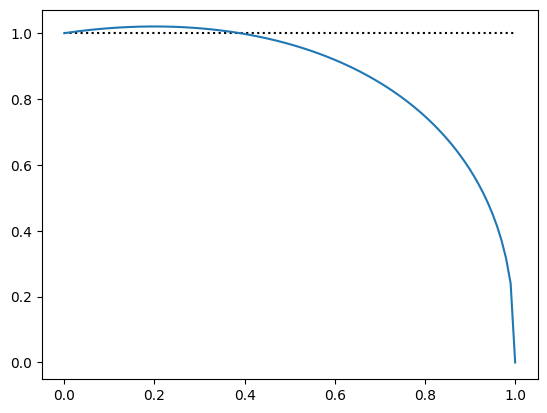

In [2]:
f = np.linspace(0, 1, 100)
p = 0.6 # 60% de probabilidad de ganar corresponde a apostar un 20% de nuestro dinero
r = (1 + f)**p * (1 - f)**(1-p)
#plt.ylim(2 - r.max(), r.max())
plt.hlines(1, 0, 1, ls=':', color='black')
plt.plot(f, r)
print(f[r.argmax()])

If we introduce tie probability the optima doesn't change, but it's also a lot more permissive regarding calling bad bets.

0.20202020202020204


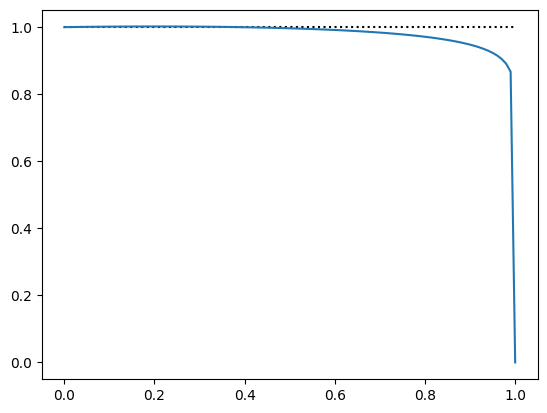

In [3]:
f = np.linspace(0, 1, 100)
p = 0.6 # 60% de probabilidad de ganar corresponde a apostar un 20% de nuestro dinero
tie = 0.9
r = (1 + f)**(p * (1 - tie)) * (1 - f)**((1-p) * (1 - tie))
#plt.ylim(2 - r.max(), r.max())
plt.hlines(1, 0, 1, ls=':', color='black')
plt.plot(f, r)
print(f[r.argmax()])

Adaptamos la fórmula del crecimiento esperado de la mediana a la posibilidad de empate:  
$p_w$ = probability of winning  
$p_l$ = probability of losing  
$p_t$ = probability of tying  
$g$ = expected median growth function  
$f$ = fraction bet  
$$g(f) = (1 + f)^{p_w} \cdot (1 - f)^{p_l} \cdot 1^{p_{tie}} = (1 + f)^{p_w} \cdot (1 - f)^{p_l}$$

Una mejor forma de observar el cambio es en vez de tomar la probabilidad de ganar global y la probabilidad de perder global, tomar las probabilidades condicionadas de no empatar.
$p_{wt}$ = probability of winning given no tie  
$p_{lt}$ = probability of losing given no tie  
$p_t$ = probability of tying
$$g(f) = (1 + f)^{p_{wt} \cdot (1 - p_t)} \cdot (1 - f)^{p_{lt} \cdot (1 - p_t)}$$

Si se deriva se puede ver que fracción óptima se mantiene.
$$ln(g(f)) = ln((1 + f)^{p_{wt} \cdot (1 - p_t)} \cdot (1 - f)^{p_{lt} \cdot (1 - p_t)})$$
$$ln(g(f)) = ln((1 + f)^{p_{wt} \cdot (1 - p_t)}) + ln((1 - f)^{p_{lt} \cdot (1 - p_t)})$$
$$ln(g(f)) = p_{wt} \cdot (1 - p_t) \cdot ln(1 + f) + p_{lt} \cdot (1 - p_t) \cdot ln(1 - f)$$
Derivar:
$$\frac{g'(f)}{g(f)} = p_{wt} \cdot (1 - p_t) \cdot \frac{1}{1 + f} + p_{lt} \cdot (1 - p_t) \cdot \frac{-1}{1 - f}$$
Tomando el máximo ($g'(f) = 0$):
$$p_{wt} \cdot (1 - p_t) \cdot \frac{1}{1 + f^*} - p_{lt} \cdot (1 - p_t) \cdot \frac{1}{1 - f^*} = 0$$
$$(1 - p_t) \cdot (p_{wt} \cdot \frac{1}{1 + f^*} - p_{lt} \cdot \frac{1}{1 - f^*}) = 0$$
$$p_{wt} \cdot \frac{1}{1 + f^*} - p_{lt} \cdot \frac{1}{1 - f^*} = 0$$
Multiplicando ambos lados por $1 + f^*$:
$$p_{wt} - p_{lt} \cdot \frac{1 + f^*}{1 - f^*} = 0$$
$$p_{lt} \cdot \frac{1 + f^*}{1 - f^*} = p_{wt} $$
$$\frac{1 + f^*}{1 - f^*} = \frac{p_{wt}}{p_{lt}}$$
$$1 + f^* = \frac{p_{wt}}{p_{lt}} \cdot (1 - f^*)$$
$$f^* + f^* \cdot \frac{p_{wt}}{p_{lt}} = \frac{p_{wt}}{p_{lt}} - 1$$
$$f^* \cdot (1 + \frac{p_{wt}}{p_{lt}}) = \frac{p_{wt}}{p_{lt}} - 1$$
$$f^* = \frac{\frac{p_{wt}}{p_{lt}} - 1}{1 + \frac{p_{wt}}{p_{lt}}}$$
$$f^* = \frac{\frac{p_{wt} - p_{lt}}{p_{lt}}}{\frac{p_{lt} + p_{wt}}{p_{lt}}}$$
$$f^* = \frac{p_{wt} - p_{lt}}{p_{lt} + p_{wt}}$$
Considerando que $p_{wt}$ y $p_{lt}$ son complementarios: ($p_{wt} + p_{lt} = 1$)
$$f^* = p_{wt} - p_{lt}$$


No olvidemos la formula que establece un umbral entre retirarse e ir a una apuesta más alta de lo que se quiere:
$$\frac{r_c(n)}{m(n)} < (1 + f)^{p_w} \cdot (1 - f)^{p_l}$$

## Resumen

No es sabio apostar todo de golpe el porcentaje correcto, al igual que puede ser una desventaja el hecho de que haya varias rondas que supongan un cambio en los porcentajes y un elemento caótico de apuestas del rival, también puede tomarse como ventaja e ir apostando incrementalmente, ya que la decisión no es tan radical sino paulatina. Habría que buscar una curva que capture un buen incremento de las apuestas considerando las decisiones correspondientes del rival. El primer modelo en mente es uno exponencial.

También es esencial estudiar el comportamiento del rival y la magnitud de sus apuestas, hay contrincantes que apuestan debidamente y la cantidad apostada se relaciona bastante bien con la fuerza de su mano. No obstante, por ejemplo hay otros que apuestan fuerte siempre.

También hay en ocasiones en las que el modelo se la tiene que jugar, por ejemplo, el rival hace all-in todas las rondas aunque hayamos apostado poco, con el tiempo podría sacarnos de la partida a base de esta estrategia. (PENDIENTE)
Opciones:
- A partir de qué punto es suficiente porcentaje para jugarse la partida.
- Intentar predecir faroles.

En resumen el modelo hace lo siguiente:
- Calcula cuánto debería apostar para su mayor crecimiento económico.
    - Hand evaluator
    - Implementar la base del modelo estadístico
- Apuesta una fracción de eso siguiendo una curva.
    - Estudiar tendencia de apuestas basada en probabilidad de ganar
    - Buscar algo que optimizar
- Aprende la tendencia de las apuestas para asumir más correctamente el riesgo.
    - Estudiar tendencia de apuestas
- Toma decisiones teniendo en cuenta las probabilidades de perder bajo retirada versus no retirada.

### Curva de apuestas

1. La mejor cantidad que apostar basándose en nuestro beneficio es cualquier curva que llegue al punto óptimo estadístico.  
1. El modelo debería poner al rival en una situación en la que tanto retirarse como participar son igual de malas/buenas decisiones.

El problema es que el segundo punto determina univocamente cuánto deberíamos apostar, entonces no se estaría teniendo en cuenta el primer punto que es la base del modelo.
- Si el punto 1 dice que apostemos menos, deberíamos hacerlo.
- Si el punto 1 dice que apostemos más, aquí hay un problema, porque si lo hacemos, el oponente se vería animado a retirarse.

Podríamos ir ajustando un factor greedy que determina cuánto se apuesta e ir ajustándolo según oponente. Este factor greedy sólo interpolaría entre ambos valores y sólo aplica si estadísticamente queremos apostar más, pero el sistema de toma de decisiones nos dice que el oponente se va a retirar.

### Tendencia de apuestas

Queremos evaluar cómo crecen la magnitud de las apuestas dependiendo de varias situaciones con distintas cantidades de información.  
Una opción es entrenar un modelo por fase de juego: pre flop, flop, turn y river.